<a href="https://colab.research.google.com/github/apchavezr/prueba_trabajo/blob/main/Ejercicio_Modelo_Ausentismo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ejercicio: evaluación del modelo de predicción de ausentismo**

Este ejercicio se puede desarrollar en Google Colab, y simula el entrenamiento y validación de un modelo de clasificación binaria para predecir ausencias laborales.

Este ejercicio permite aplicar los conceptos, haciendo énfasis en:

* Cómo se calculan y se interpretan los indicadores de desempeño.

* Cómo se valida la estabilidad del modelo con cross-validation.

* Cómo se analiza la influencia de cada variable predictora.

In [1]:
# Instalación (si es necesario en Colab)
# !pip install scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


# **Generación aleatoria de datos**
Se usa numpy para generar un DataFrame con 1000 registros, representando a empleados del hospital. Cada registro incluye variables potencialmente relacionadas con la probabilidad de ausentismo:

* edad: valores aleatorios entre 22 y 65 años.

* tipo_contrato: se asigna aleatoriamente entre tres tipos: 'planta', 'provisional' y 'contratista'.

* area: área de trabajo, elegida entre 'urgencias', 'hospitalización' y 'consulta externa'.

* historial_incapacidades: número de incapacidades previas (entre 0 y 9).

* turno_nocturno: indica si trabaja de noche (1) o no (0).

* ausente: variable objetivo (target), que indica si el empleado estuvo ausente o no (1 = ausente, 0 = presente), con una proporción de 70% no ausentes y 30% ausentes, lo que refleja un desbalance de clases, típico en problemas reales.

In [2]:
# Simulamos un dataset (en un caso real, se cargan los datos)
np.random.seed(42)
n = 1000
df = pd.DataFrame({
    'edad': np.random.randint(22, 65, size=n),
    'tipo_contrato': np.random.choice(['planta', 'provisional', 'contratista'], size=n),
    'area': np.random.choice(['urgencias', 'hospitalización', 'consulta externa'], size=n),
    'historial_incapacidades': np.random.randint(0, 10, size=n),
    'turno_nocturno': np.random.choice([0, 1], size=n),
    'ausente': np.random.choice([0, 1], size=n, p=[0.7, 0.3])  # Desbalanceado
})
df.head()


,edad,tipo_contrato,area,historial_incapacidades,turno_nocturno,ausente
0,60,planta,urgencias,7,0,0
1,50,contratista,hospitalización,1,0,0
2,36,provisional,consulta externa,9,0,0
3,64,planta,consulta externa,3,0,0
4,29,provisional,hospitalización,5,1,1


In [4]:
# Codificación de variables categóricas
df_encoded = pd.get_dummies(df, drop_first=True)

# Separar variables predictoras y variable objetivo
X = df_encoded.drop('ausente', axis=1)
y = df_encoded['ausente']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)


(800, 7) (200, 7)


* (800, 7): el conjunto de entrenamiento tiene 800 filas (observaciones) y 7 columnas (variables predictoras).

* (200, 7): el conjunto de prueba tiene 200 filas y las mismas 7 variables predictoras.

Este resultado confirma que la codificación de variables categóricas funcionó correctamente y que ahora se dispone de un conjunto de datos numérico y estructurado.

In [5]:
# Entrenamiento con Random Forest
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

# Cálculo de métricas
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precisión: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precisión: {precision:.2f}")
print(f"F1-score: {f1:.2f}")


Precisión: 0.65
Recall: 0.09
Precisión: 0.13
F1-score: 0.10


1. Precisión (Accuracy = 0.65):

* El 65% de las predicciones totales (ausente o no ausente) fueron correctas.

*  Sin embargo, esta métrica puede ser engañosa cuando las clases están desbalanceadas (como en este caso, con solo el 30% de ausentes), ya que el modelo puede acertar simplemente prediciendo la clase mayoritaria (no ausente).

1. Recall (Sensibilidad = 0.09):

* De todos los empleados que realmente estuvieron ausentes, solo el 9% fueron identificados correctamente por el modelo.

* Este valor es muy bajo, lo cual es problemático si el objetivo es detectar posibles ausencias.

1. Precisión (Precision = 0.13):

* Solo el 13% de los empleados que el modelo predijo como ausentes realmente lo estuvieron.

* Indica un alto número de falsos positivos, es decir, empleados mal clasificados como ausentes.

1. F1-score = 0.10:

*  Es la media armónica entre precisión y recall, y refleja un equilibrio general deficiente del modelo para la clase minoritaria ("ausente").

*  Un valor de 0.10 indica que el modelo no logra balancear adecuadamente la detección de verdaderos positivos y la evitación de falsos positivos.

In [6]:
# Validación con K-Fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = cross_val_score(modelo, X, y, cv=kfold, scoring='f1')

print("F1-scores en validación cruzada:", f1_scores)
print(f"F1 promedio: {f1_scores.mean():.2f} ± {f1_scores.std():.2f}")


F1-scores en validación cruzada: [0.1686747  0.21978022 0.24742268 0.24489796 0.24096386]
F1 promedio: 0.22 ± 0.03


1. F1 promedio = 0.22:

* El modelo tiene un bajo rendimiento al predecir correctamente los casos positivos (ausentismo).

* Aunque mejora respecto al F1-score individual observado anteriormente (≈ 0.10), aún indica un rendimiento limitado en detectar casos ausentes con precisión y sensibilidad al mismo tiempo.

1. Desviación estándar = ±0.03:

* Refleja que el modelo tiene un desempeño relativamente estable entre las distintas particiones del conjunto de datos.

* No hay grandes variaciones, lo que sugiere consistencia en la pobre capacidad predictiva.

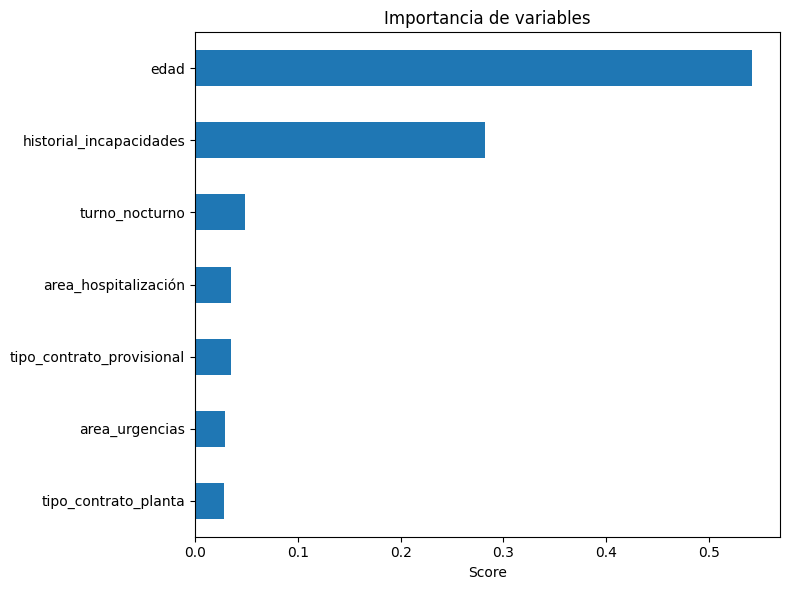

In [7]:
# Visualización de importancia de variables
importancias = modelo.feature_importances_
features = X.columns
feat_imp = pd.Series(importancias, index=features).sort_values(ascending=True)

plt.figure(figsize=(8,6))
feat_imp.plot(kind='barh')
plt.title("Importancia de variables")
plt.xlabel("Score")
plt.tight_layout()
plt.show()


 **Variables con mayor importancia:**

1. edad (~0.53):

    * Es la variable más influyente.

    *  Esto sugiere que la edad tiene una relación significativa con el ausentismo laboral, posiblemente indicando que ciertos grupos etarios (por ejemplo, mayores de 50 años) presentan patrones de ausencia más frecuentes.

2. historial_incapacidades (~0.30):

    * También aporta fuertemente al modelo.

    * Es lógico pensar que las personas con más incapacidades previas tienen una mayor probabilidad de ausentismo futuro.

**Variables con baja importancia:**

3. turno_nocturno, area_hospitalización, tipo_contrato_provisional, area_urgencias, tipo_contrato_planta (~<0.05):

  * Estas variables tienen muy poco peso en la toma de decisiones del modelo.

  * Esto puede deberse a que su distribución no varía significativamente entre las clases (ausente/no ausente), o a que su impacto real sobre la variable objetivo es limitado.